# Walmart Recruiting - Prognoza vânzărilor în magazin
#### *Proiect realizat de Bargan Diana-Georgiana, Data Mining, FEAA*

**Obiectivele proiectului:**
1. Analiza exploratorie a datelor 
2. Determinarea și detalierea fenomenului studiat în funcție de construirea unor modele de scoring 
3. Interpretarea rezultatelor si prezentarea concluziilor aferente in urma primelor doua obiective.
4. Realizare interogari SQL-Spark 



**Descrierea prelucrarii setului de date inainte de analiza exploratorie.** \
Setul de date utilizat numit "walmart.csv" a fost creat prin imbinarea altor 3 seturi de date pe coloane comune, ce au fost descarcate de pe site-ul Kaggle [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data). Cele 3 seturi de date folosite sunt: "stores.csv", "train.csv" si "features.csv". \
Scurta descriere a fiecarui fisier:
* **stores.csv** - acest fisier include informatii despre cele 45 de magazine, indicând tipul si dimensiunea magazinului.
* **train.csv** - conține datele istorice ale vânzărilor săptămânale ale fiecărui departament: _Store, Dept, Date, Weekly_Sales (vânzări pentru departamentul respectiv din magazinul dat), IsHoliday_
* **features.csv** - conține caracteristici suplimentare referitoare la magazin: _Store, Date, Temperature, Fuel_Price, MarkDown1-5, IPC, Unemployment, IsHoliday (dacă săptămâna este o săptămână specială de vacanță)_

Setul de date final **"walmart.csv"** a fost curatat si prelucrat inainte de a fi folosit in urmatoarele analize de la punctele 1 si 2.


In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = (
    SparkSession.builder.appName("Spring1-111")
    .config("spark.executor.memory", "1G")
    .config("spark.executor.cores", "1")
    .config("spark.cores.max", "3")
    .config("spark.master", "spark://master:7077")
    #mai multe la https://spark.apache.org/docs/latest/configuration.html
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/01 18:56:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
#Citirea setului de date 'walmart.csv'
df_walmart = spark.read.csv("/proiectdm1105/walmart.csv", inferSchema=True, header=True)

In [4]:
#elimin prima coloana
df_walmart = df_walmart.drop("_c0")
#Observam ca tipul de date a fost importat corect pentru ca am folosit argumentul inferSchema cu valoarea TRUE
df_walmart.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: double (nullable = true)
 |-- MarkDown2: double (nullable = true)
 |-- MarkDown3: double (nullable = true)
 |-- MarkDown4: double (nullable = true)
 |-- MarkDown5: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)



In [5]:
#Afisarea primelor 5 randuri a setului de date
df_walmart.show(5, truncate = True)

+-----+----------+---------+----+------------+----+------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|Store|      Date|IsHoliday|Dept|Weekly_Sales|Type|  Size|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|
+-----+----------+---------+----+------------+----+------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|    1|2010-02-05|    false|   1|     24924.5|   A|151315|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.0963582|       8.106|
|    1|2010-02-05|    false|  45|       37.44|   A|151315|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.0963582|       8.106|
|    1|2010-02-05|    false|  28|     1085.29|   A|151315|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.0963582|       8.106|
|    1|2010-02-05|    false|  95|   106690.06|   A|151315|

In [6]:
#Transform baza de date in format pandas
df = df_walmart.toPandas()
#verificare ca baza de date este de tip pandas:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


## Analiza descriptiva a setului de date

In [7]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Identificarea valorilor lipsa ###

In [8]:
print(df.isnull().sum())
#Nu exista valori lipsa in setul de date

Store           0
Date            0
IsHoliday       0
Dept            0
Weekly_Sales    0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


In [9]:
#Analiza descriptiva a tuturor variabilelor din baza de date
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Store,420212.0,22.20,12.79,1.00,11.00,22.00,33.00,45.00
Dept,420212.0,44.24,30.51,1.00,18.00,37.00,74.00,99.00
Weekly_Sales,420212.0,16033.11,22729.49,0.01,2120.13,7661.70,20271.26,693099.36
Size,420212.0,136749.73,60993.08,34875.00,93638.00,140167.00,202505.00,219622.00
Temperature,420212.0,60.09,18.45,-2.06,46.68,62.09,74.28,100.14
Fuel_Price,420212.0,3.36,0.46,2.47,2.93,3.45,3.74,4.47
MarkDown1,420212.0,2590.32,6053.42,0.00,0.00,0.00,2809.05,88646.76
MarkDown2,420212.0,878.91,5076.93,-265.76,0.00,0.00,2.40,104519.54
MarkDown3,420212.0,468.85,5534.07,-29.10,0.00,0.00,4.54,141630.61
MarkDown4,420212.0,1083.53,3896.07,0.00,0.00,0.00,425.29,67474.85


## __Statistici descriptive pentru variabila Weekly_Sales__

* ### Vanzarile saptamanale pentru fiecare tip de magazin
Observam faptul ca cea mai mica medie a vanzarilor este pentru tipul C de magazine, urmate de magazinul B si A, cu cele mai mari vanzari.
Magazinul C, desi inregistreaza cel mai mare maxim de incasari saptamanale, acesta are cea mai mica medie, 50% din totalul vanzarilor saptamanale pentru magazinul C au o valoare mai mica de 1163 dolari, in timp ce pentru magazinul A, sunt mai mici de 10155 dolari. 
Pentru magazinul A, 75% dintre vanzari cel putin egale cu 26424 dolari, in timp ce pentru magazinul B sau C aceste vanzari sunt cel putin egale cu 15412 respectiv 12744 dolari.


In [10]:
# Vanzari magazin tip A, B si C
A = df[df['Type'] == 'A']['Weekly_Sales']
statsA = A.describe().drop('count').round(2)
statsA['median'] = A.median().round(2)
B = df[df['Type'] == 'B']['Weekly_Sales']
statsB = B.describe().drop('count').round(2)
statsB['median'] = B.median().round(2)
C = df[df['Type'] == 'C']['Weekly_Sales']
statsC = C.describe().drop('count').round(2)
statsC['median'] = C.median().round(2)
# Cream DataFrame-ul cu statisticile
stats_df = pd.DataFrame({'A': statsA, 'B': statsB, 'C': statsC})
print(stats_df)

                A          B          C
mean     20148.11   12290.55    9549.45
std      26436.64   17221.87   16001.41
min          0.01       0.01       0.01
25%       3351.99    1968.90     135.17
50%      10154.66    6246.11    1163.42
75%      26423.70   15412.54   12744.23
max     474330.10  693099.36  112152.35
median   10154.66    6246.11    1163.42


* ### Skewness, kurtosis si graficul de densitate al vanzarilor saptamanale
  + Distributia are un skewness = 3, ceea ce indica o asimetrie la dreapta, iar kurtosis = 21 indica o distributie puternic leptocurtica.
  + Graficul indica o asimetrie la dreapta si o distributie puternic leptocurtica, rezultat obtinut si prin calculul indicatorilor pentru validare.

Skewness: 3.2589300585451273
Kurtosis: 21.46052384232491


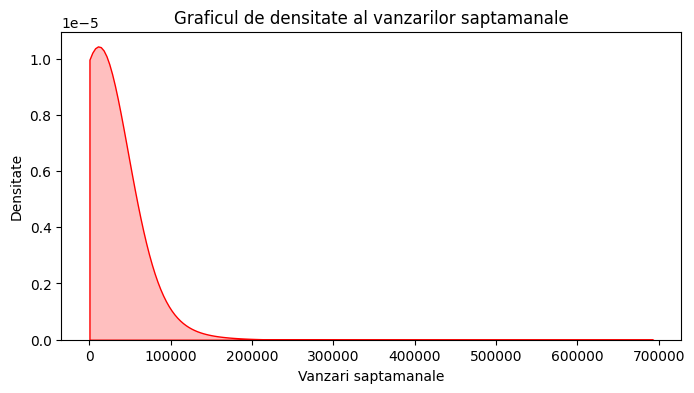

In [11]:
from scipy.stats import skew, kurtosis
# Calculam skewness si kurtosis
skewness = skew(df['Weekly_Sales'])
kurt = kurtosis(df['Weekly_Sales'])
print("Skewness:", skewness)
print("Kurtosis:", kurt)
# Cream graficul de densitate
plt.figure(figsize=(8, 4))
sns.kdeplot(df['Weekly_Sales'], color='red', fill=True,  bw_adjust=20, cut=0)
plt.title("Graficul de densitate al vanzarilor saptamanale")
plt.xlabel("Vanzari saptamanale")
plt.ylabel("Densitate")
plt.show()

* #### Histograma pentru fiecare variabila numerica

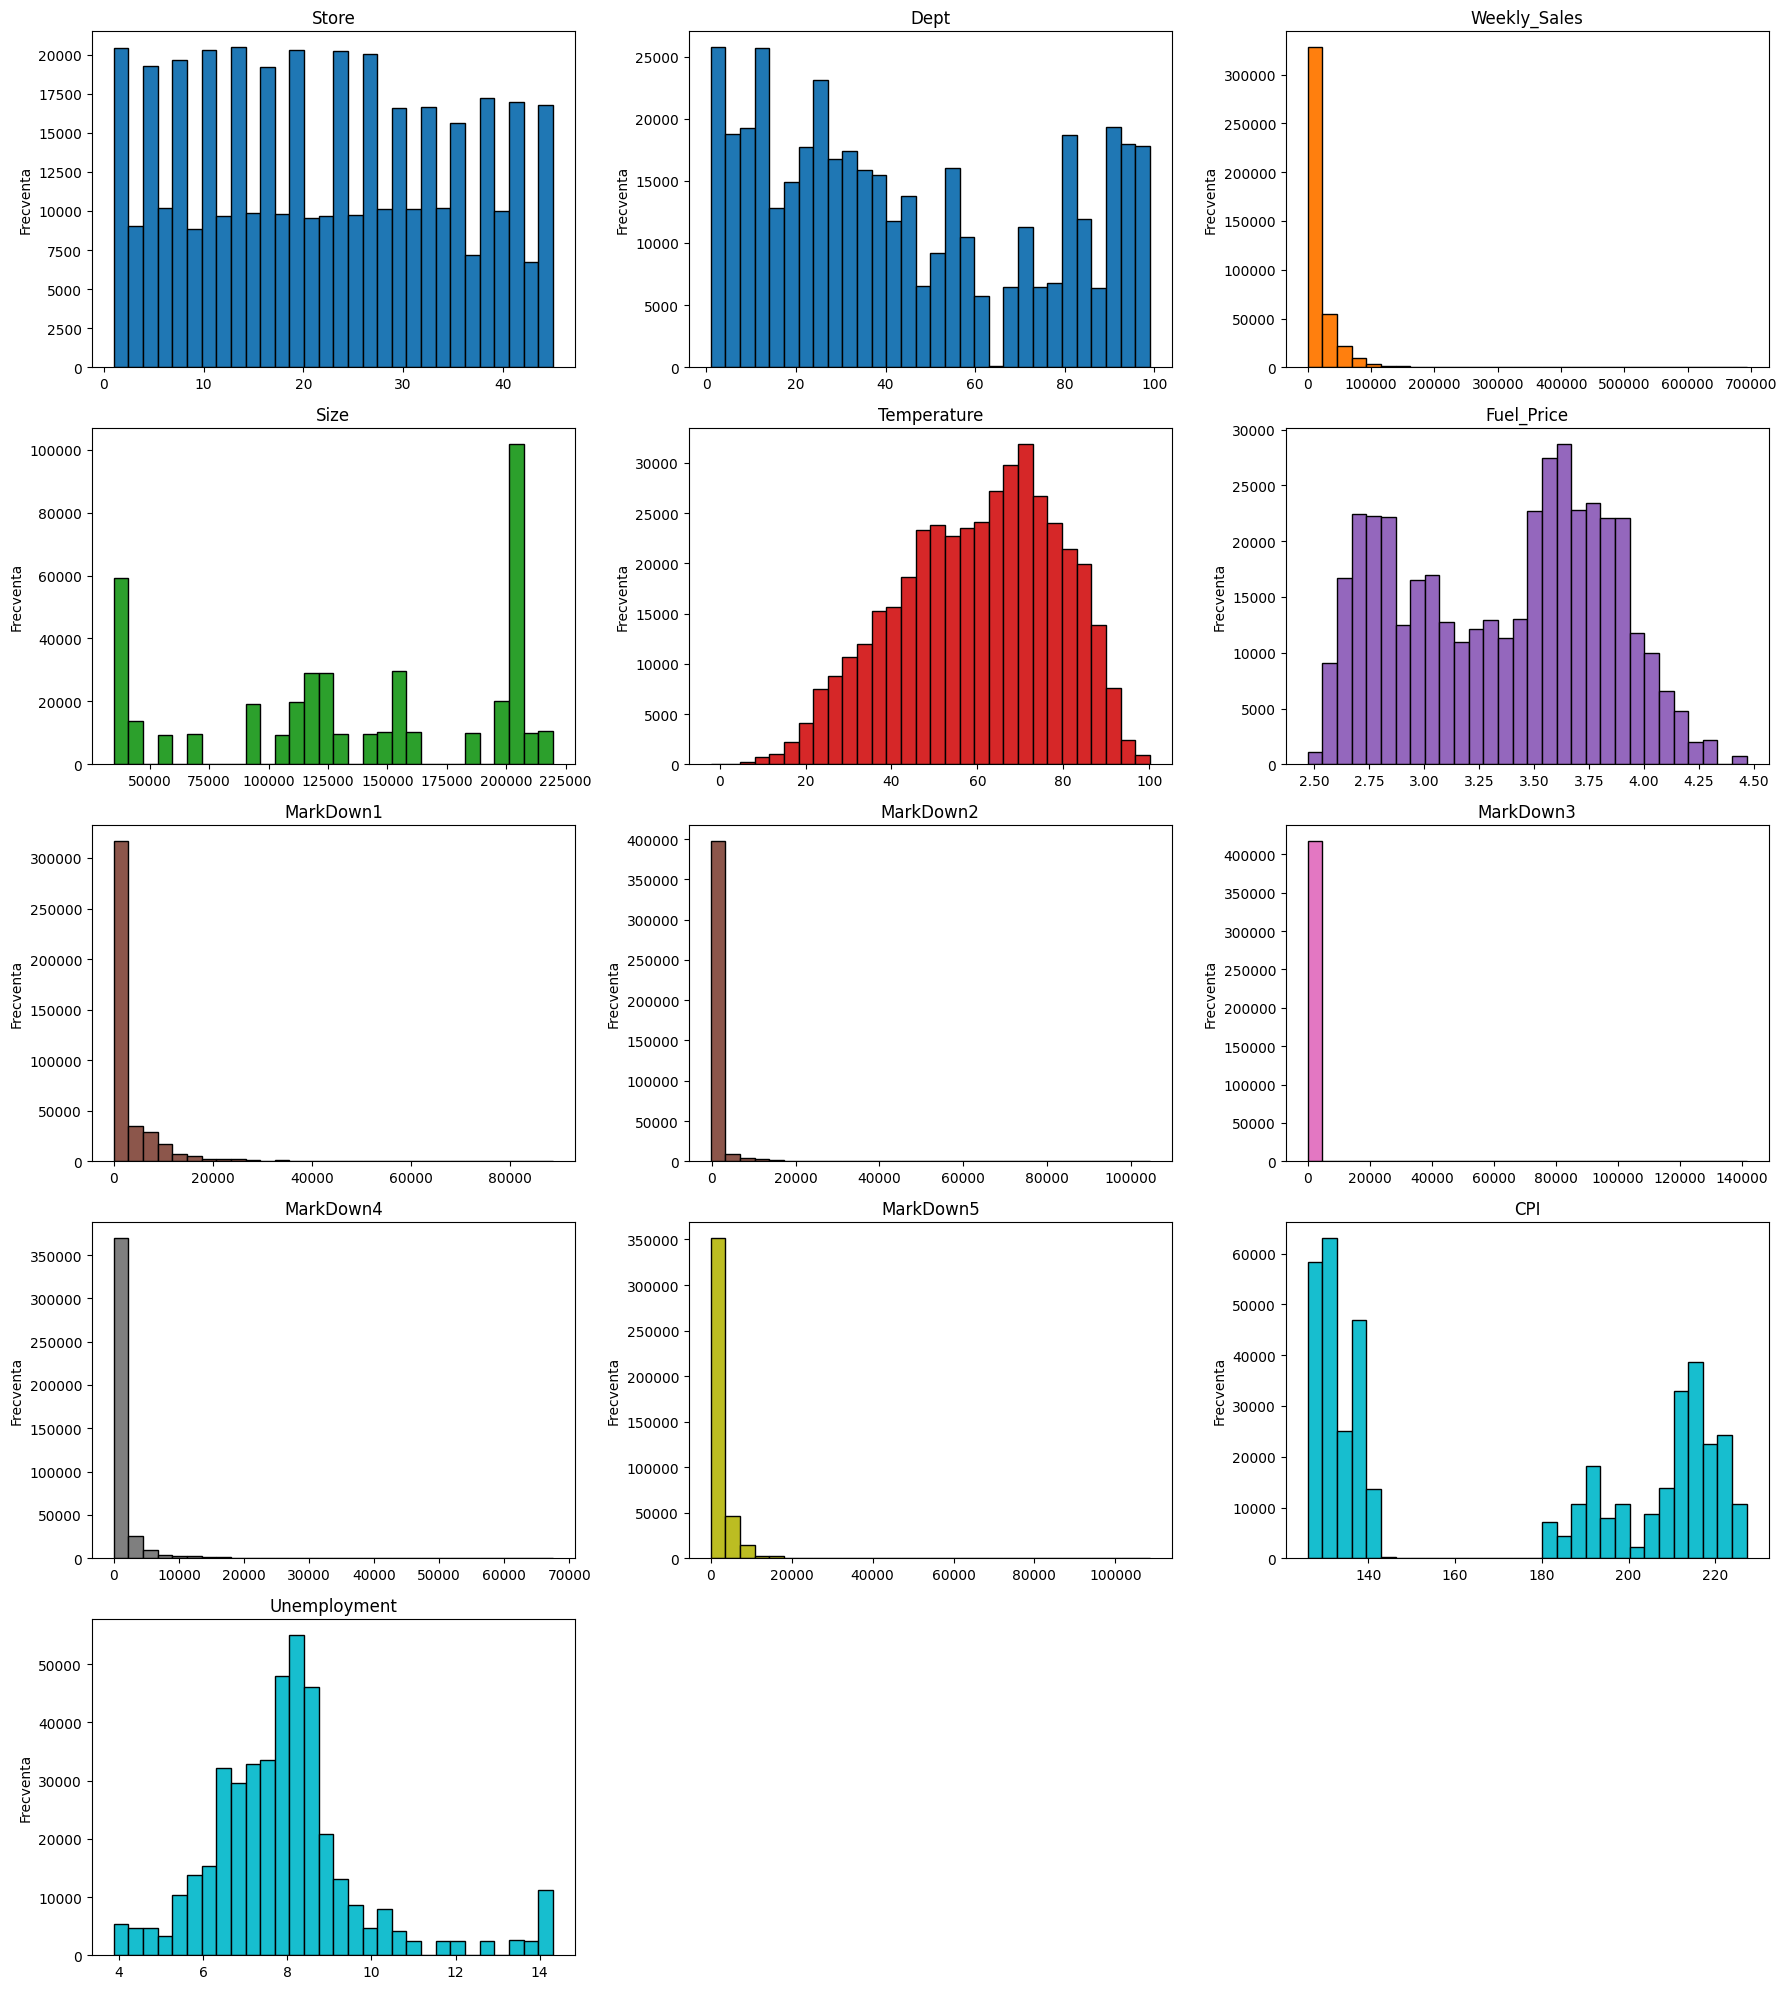

In [12]:
# Selectam doar coloanele numerice
numeric_df = df.select_dtypes(include='number')
# Calculam numarul de histograme necesare
num_plots = len(numeric_df.columns)
# Calculam numarul de randuri si coloane necesare pentru subgrafice
num_cols = 3  # Numarul de coloane pentru subgrafice
num_rows = (num_plots + num_cols - 1) // num_cols  # Numarul de randuri necesare
# Calculam dimensiunea figurii in functie de numarul de histograme si dimensiunea dorita pentru fiecare subplot
fig_width = 6 * num_cols
fig_height = 4 * num_rows
# Cream subgraficele
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
# Definim o paleta de culori pentru histograme
colors = plt.cm.tab10(np.linspace(0, 1, num_plots))
# Realizam fiecare histograma intr-un subgrafic
for i, column in enumerate(numeric_df.columns):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].hist(numeric_df[column], bins=30, color=colors[i], edgecolor='black')
    axes[row, col].set_title(f'{column}')
    axes[row, col].set_ylabel('Frecventa')

# Se elimina subgraficele goale
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()
plt.show()

* ### Popularitatea tipurilor de magazine
Din piechart se observa ca magazinele de tip A sunt mai populare decât cele de tip B și C


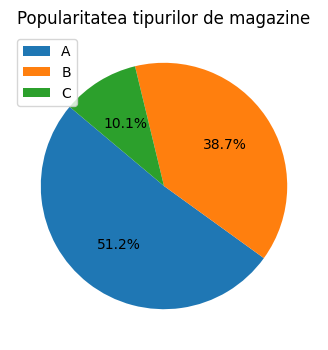

In [13]:
# Calculam numarul de aparitii ale fiecărui tip de magazin
type_counts = df['Type'].value_counts()
# Extragem numele tipurilor de magazine si numarul lor
store_types = type_counts.index
counts = type_counts.values
# Cream pie chart-ul folosind biblioteca matplotlib
plt.figure(figsize=(4, 4))
patches, texts, autotexts = plt.pie(counts, labels=None, autopct='%1.1f%%', startangle=140)
# Adaugam legenda pentru culori
plt.legend(labels=store_types, loc="best")
plt.title('Popularitatea tipurilor de magazine')
plt.show()

* ### Vanzarile medii - tip magazin
Pe baza graficului nostru cu bare, se observa ca magazinele de tip „A” au cele mai mari vanzări in comparatie cu celelalte doua magazine. Acest lucru ne spune ca exista o relatie directa intre dimensiunea magazinului si vanzarile lor corespunzatoare. Magazinele de tip „B” au locul al doilea ca marime, numarul de magazine precum si vanzarile medii, dovedind astfel aceasta ipoteza.



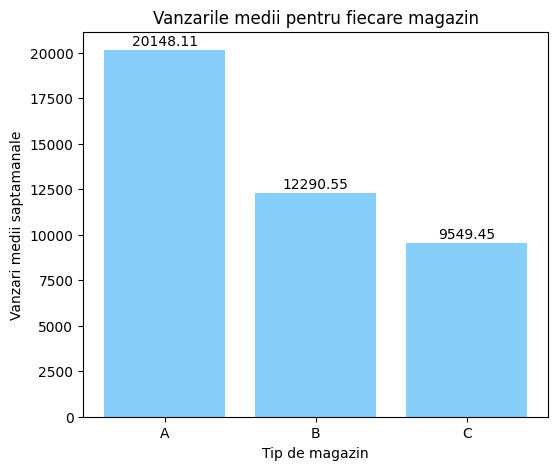

In [14]:
# Calculam vanzarile medii pentru fiecare tip de magazin
avg_weekly_sales = df.groupby('Type')['Weekly_Sales'].mean().reset_index()
# Cream DataFrame-ul pentru grafic
df_avg_weekly_sales = pd.DataFrame({'Store_Type': avg_weekly_sales['Type'], 'AvgSales': avg_weekly_sales['Weekly_Sales']})

# Cream graficul utilizând matplotlib
plt.figure(figsize=(6, 5))
bars = plt.bar(df_avg_weekly_sales['Store_Type'], df_avg_weekly_sales['AvgSales'], color='lightskyblue')
plt.title('Vanzarile medii pentru fiecare magazin')
plt.xlabel('Tip de magazin')
plt.ylabel('Vanzari medii saptamanale')
for bar, sale in zip(bars, df_avg_weekly_sales['AvgSales']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 75, f'{sale:.2f}', ha='center', va='bottom')
plt.show()

* ### Vanzarile medii pentru fiecare departament:
Din imagine, se observa ca diferite departamente au prezentat niveluri diferite de vânzări medii. Departamentele cu numerele __92,95,38,72,65,40__ prezinta cel mai mare număr de vânzări medii.



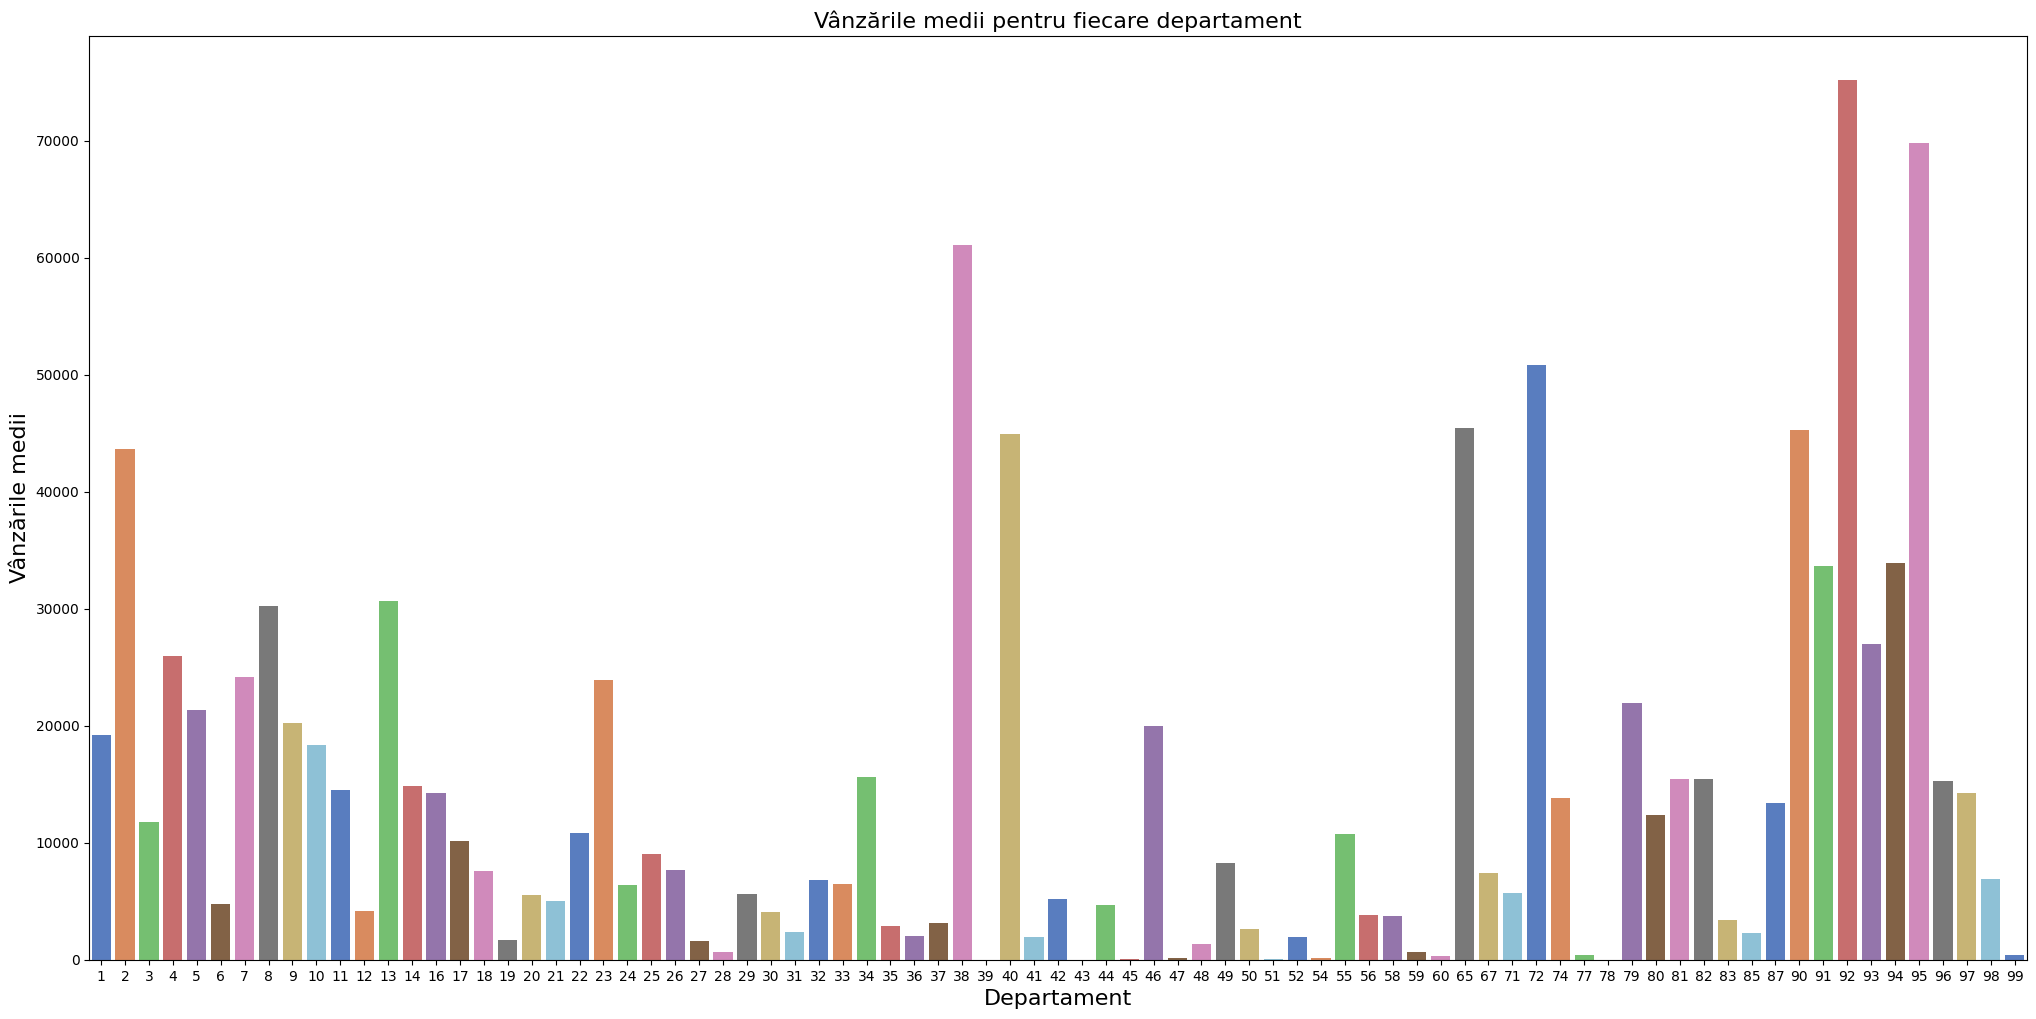

In [15]:
department_sales = df.groupby('Dept')['Weekly_Sales'].mean().reset_index().sort_values(by='Weekly_Sales', ascending=False)
# Cream graficul utilizând seaborn, cu departamentele pe axa x 
plt.figure(figsize=(25, 12))
sns.barplot(x='Dept', y='Weekly_Sales', data=department_sales, hue='Dept', palette='muted', legend=False)
plt.title('Vânzările medii pentru fiecare departament', fontsize = 16)
plt.xlabel('Departament', fontsize = 16)
plt.ylabel('Vânzările medii', fontsize = 16)
plt.show()

* ### Vanzarile medii per magazin (din cele 45)
Din graficul cu bare observam ca magazinele __20,4,14,13,2__ au cele mai mari vânzări medii in toti cei trei ani. De asemenea, trebuie remarcat faptul că există o diferență foarte mare între  vânzările medii pentru fiecare dintre magazine; în timp ce unele magazine înregistrează vânzări uriașe, altele lipsesc foarte mult în zonă. Acest lucru ar putea depinde de factori precum tipurile de produse vândute de magazin, locația geografică, temperatura, șomajul din vecinătate etc. Un studiu suplimentar arată că toate aceste trei 
magazine aparțin magazinului de tip A care adună cele mai mari vânzări din toate cele trei tipuri de magazine.



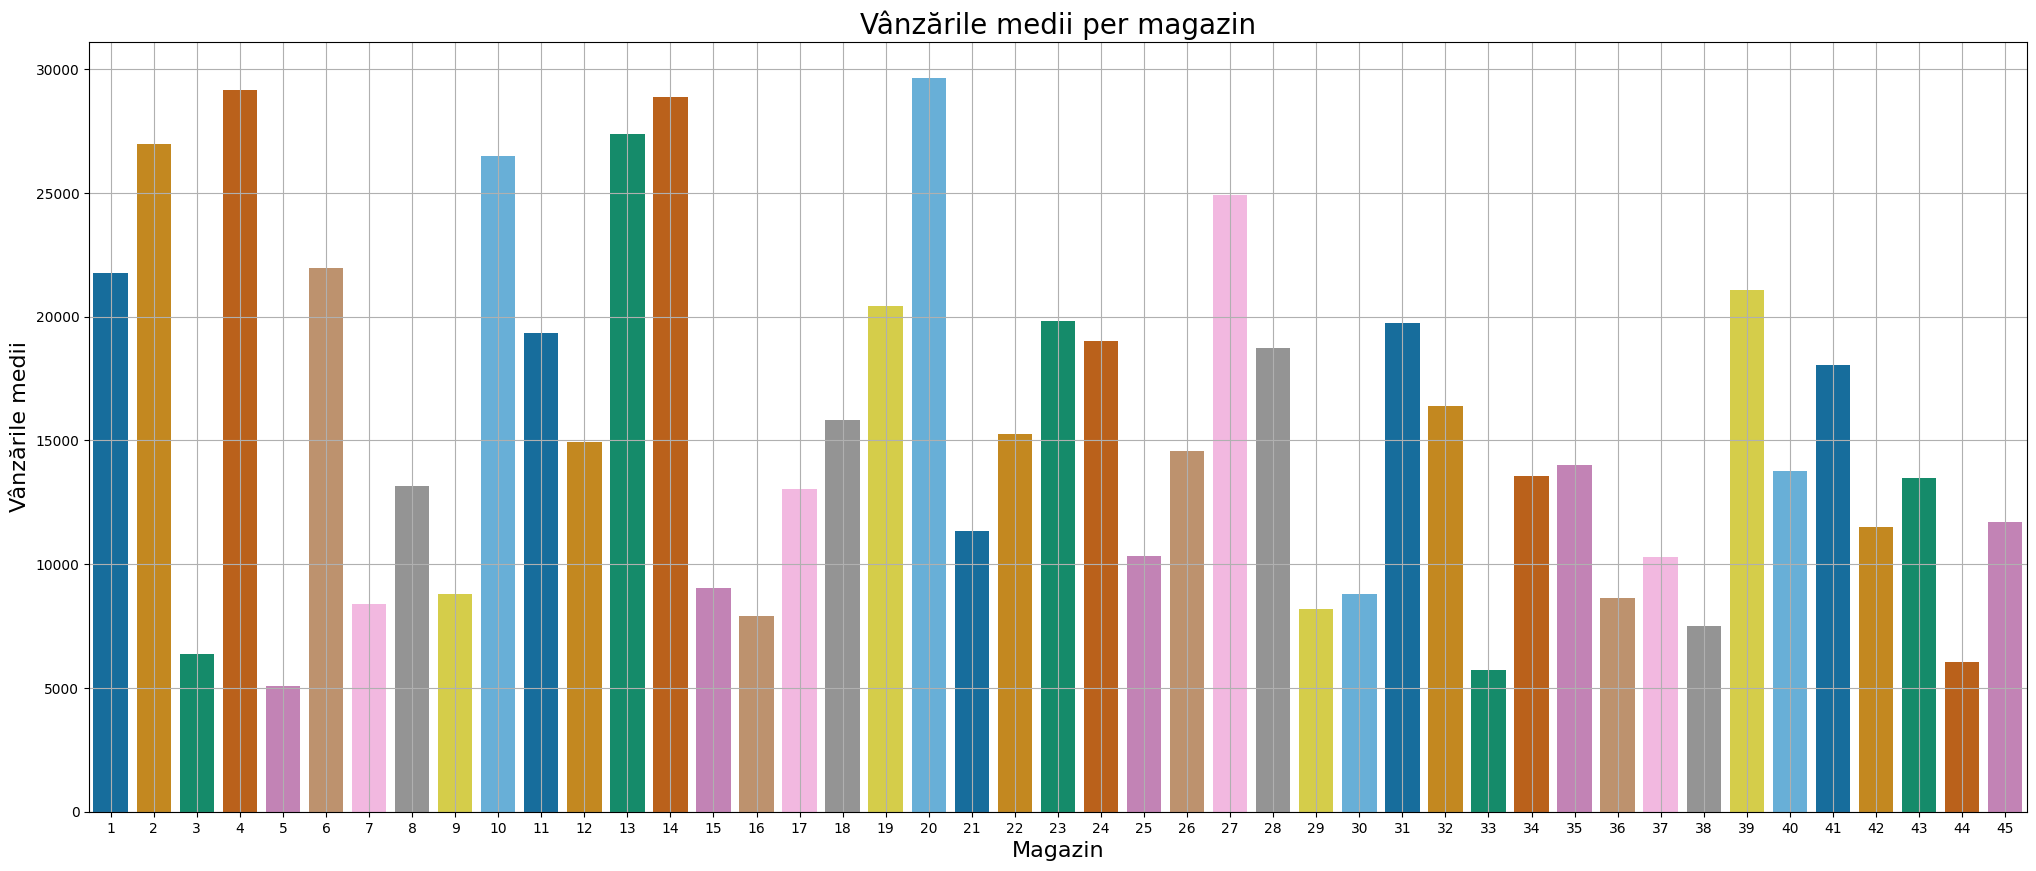

In [16]:
store_sales = df['Weekly_Sales'].groupby(df['Store']).mean().reset_index().sort_values(by='Weekly_Sales', ascending=False)
# Cream graficul utilizând seaborn, cu magazinul pe axa y (orizontală) și vânzările medii pe axa x
plt.figure(figsize=(25, 10))
sns.barplot(x='Store', y='Weekly_Sales', data=store_sales, hue='Store', palette='colorblind', legend=False)
plt.grid()
plt.title('Vânzările medii per magazin', fontsize=20)
plt.ylabel('Vânzările medii', fontsize=16)
plt.xlabel('Magazin', fontsize=16)
plt.show()

* ### Creare boxplot Type Size Store
Marimea tipului de magazine este in concordanta cu vanzarile, asa cum era de asteptat. Magazinele de dimensiuni mai mari au vanzari mai mari. Walmart clasifica magazinele in functie de dimensiunile lor conform graficului. Dupa cea mai mica valoare de dimensiune a tipului A, incepe tipul B, apoi tipul C.




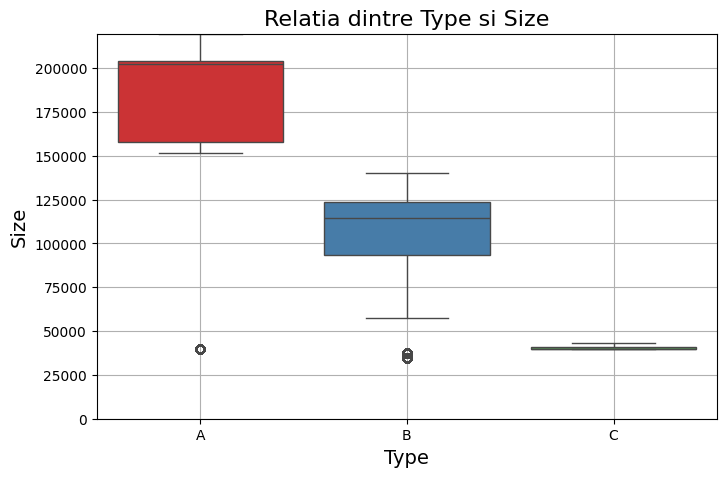

In [17]:
# Cream un boxplot folosind Seaborn
plt.figure(figsize=(8, 5))
sns.boxplot(data= df, x='Type', y='Size', hue='Type', palette='Set1', legend=False)
plt.title('Relatia dintre Type si Size', fontsize=16)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Size', fontsize=14)
plt.ylim(0, df['Size'].max())  # Limităm intervalul pe axa y la maximul mărimii
plt.grid(True)
plt.show()

In [18]:
#Creare coloane Year, Month si WeekOfYear in setul de date
# Convertim coloana 'Date' la tipul datetime
df['Date'] = pd.to_datetime(df['Date'])
# Cream coloanele 'Year', 'Month' si 'WeekOfYear'
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
# Verificam daca am obtinut cele 3 coloane:
print(df.head(2))

   Store       Date  IsHoliday  Dept  Weekly_Sales Type    Size  Temperature  \
0      1 2010-02-05      False     1      24924.50    A  151315        42.31   
1      1 2010-02-05      False    45         37.44    A  151315        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment  Year  Month  WeekOfYear  
0  211.096358         8.106  2010      2           5  
1  211.096358         8.106  2010      2           5  


* ### Vanzarile saptamanale medii - pe ani
Saptamanal, in saptamana sarbatorii de Ziua Recunostintei si cu o saptamana inainte de Craciun, au fost cele mai mari vanzari din anii 2010 si 2011. In 2012 saptamana nr. 14 a inregistrat cele mai mari vanzari in comparatie cu alte saptamani ale anului, dar asta nu corespunde cu nicio sarbatoare sau vreun eveniment special.


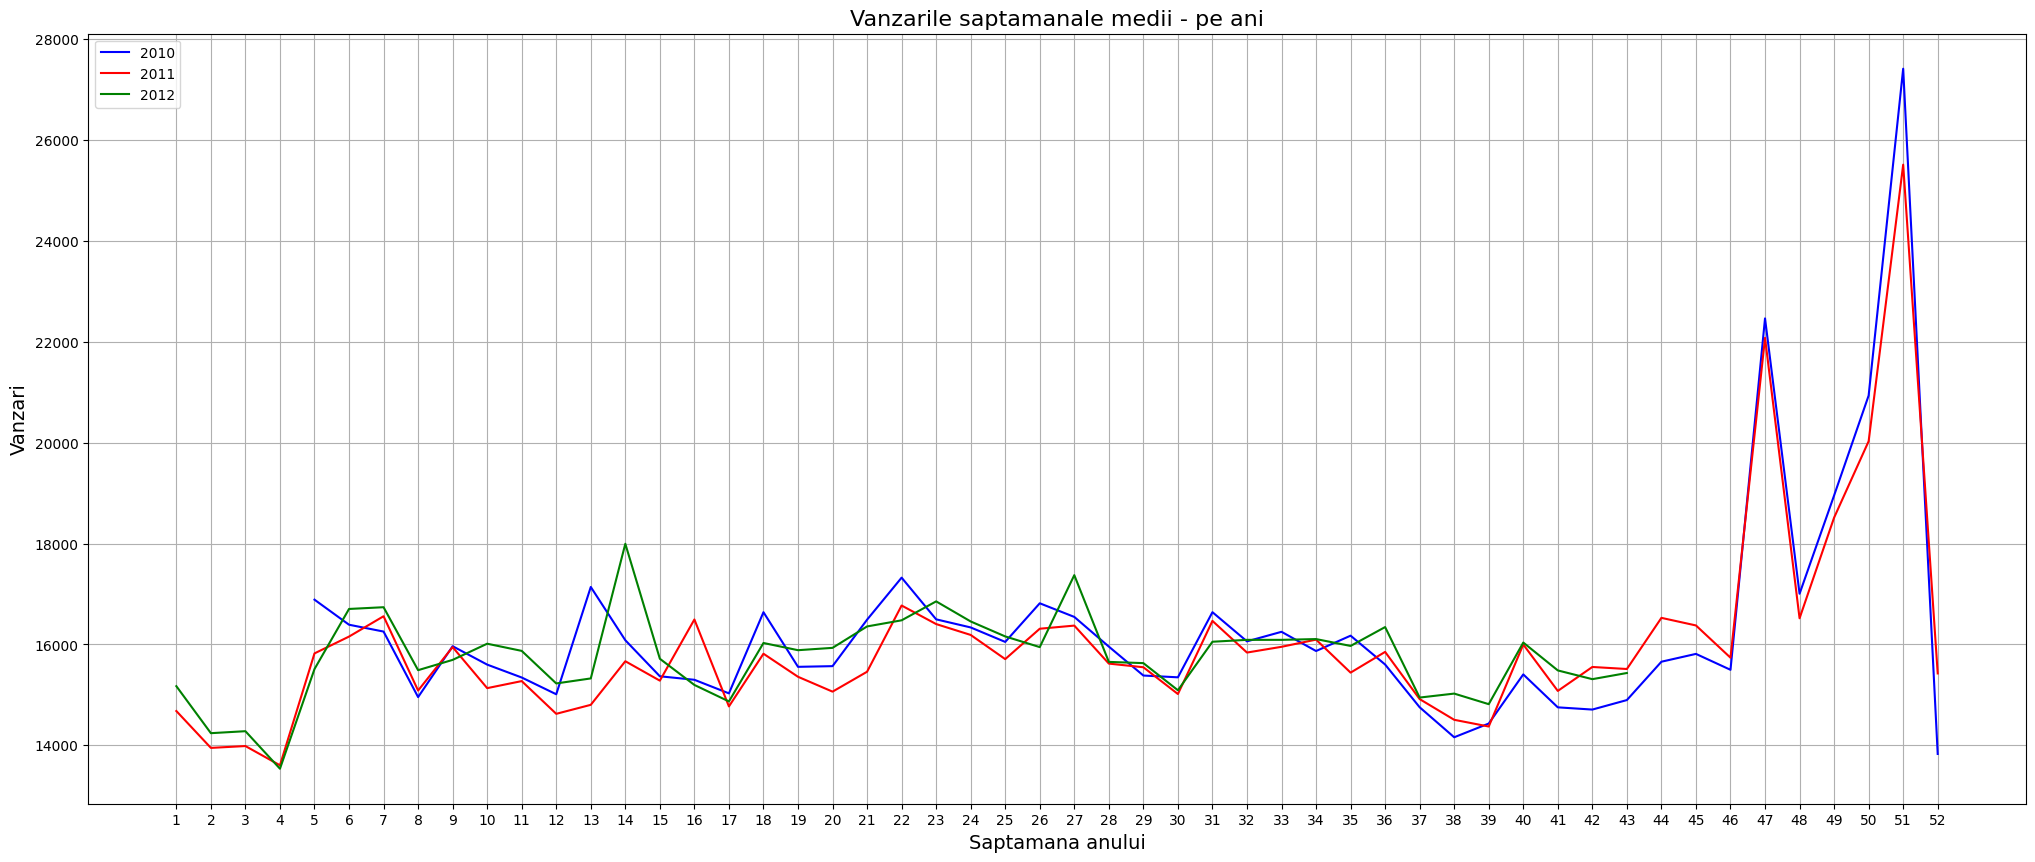

In [19]:
# Filtram datele pentru fiecare an si calculam vanzările medii saptamanale
weekly_sales_2010 = df[df['Year'] == 2010].groupby('WeekOfYear')['Weekly_Sales'].mean().reset_index()
weekly_sales_2010['Year'] = '2010'  # Adaugam coloana Year
weekly_sales_2011 = df[df['Year'] == 2011].groupby('WeekOfYear')['Weekly_Sales'].mean().reset_index()
weekly_sales_2011['Year'] = '2011'  # Adaugam coloana Year
weekly_sales_2012 = df[df['Year'] == 2012].groupby('WeekOfYear')['Weekly_Sales'].mean().reset_index()
weekly_sales_2012['Year'] = '2012'  # Adaugam coloana Year
# Combinam datele pentru toti cei trei ani
combined_data = pd.concat([weekly_sales_2010, weekly_sales_2011, weekly_sales_2012], ignore_index=True)
# Cream graficul utilizând Matplotlib
plt.figure(figsize=(25, 10))
colors = ['blue', 'red', 'green']
for i, year in enumerate(combined_data['Year'].unique()):
    data = combined_data[combined_data['Year'] == year]
    plt.plot(data['WeekOfYear'], data['Weekly_Sales'], label=year, color=colors[i]) 
plt.xlabel('Saptamana anului', fontsize=14)
plt.ylabel('Vanzari', fontsize=14)
plt.title('Vanzarile saptamanale medii - pe ani', fontsize=16)
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(range(1, 53)) # Afisam toate saptamanile pe axa x
plt.show()

* ### Vanzarile medii lunare medii pentru fiecare an
Observatii din grafic:
1. Luna ianuarie a avut cele mai scăzute vânzări pentru anii 2011 și 2012, în timp ce pentru anul 2010  nu au fost inregistrare vânzările săptămânale.
2. Din Luna Februarie până în Octombrie, vânzările săptămânale rămân aproape constante în jurul valorii de 15000 pentru cei 3 ani.
3. Lunile Noiembrie și Decembrie au înregistrat cele mai mari vânzări pentru 2010 și 2011, în timp ce pentru 2012 datele de vânzări 
nu au fost furnizate.



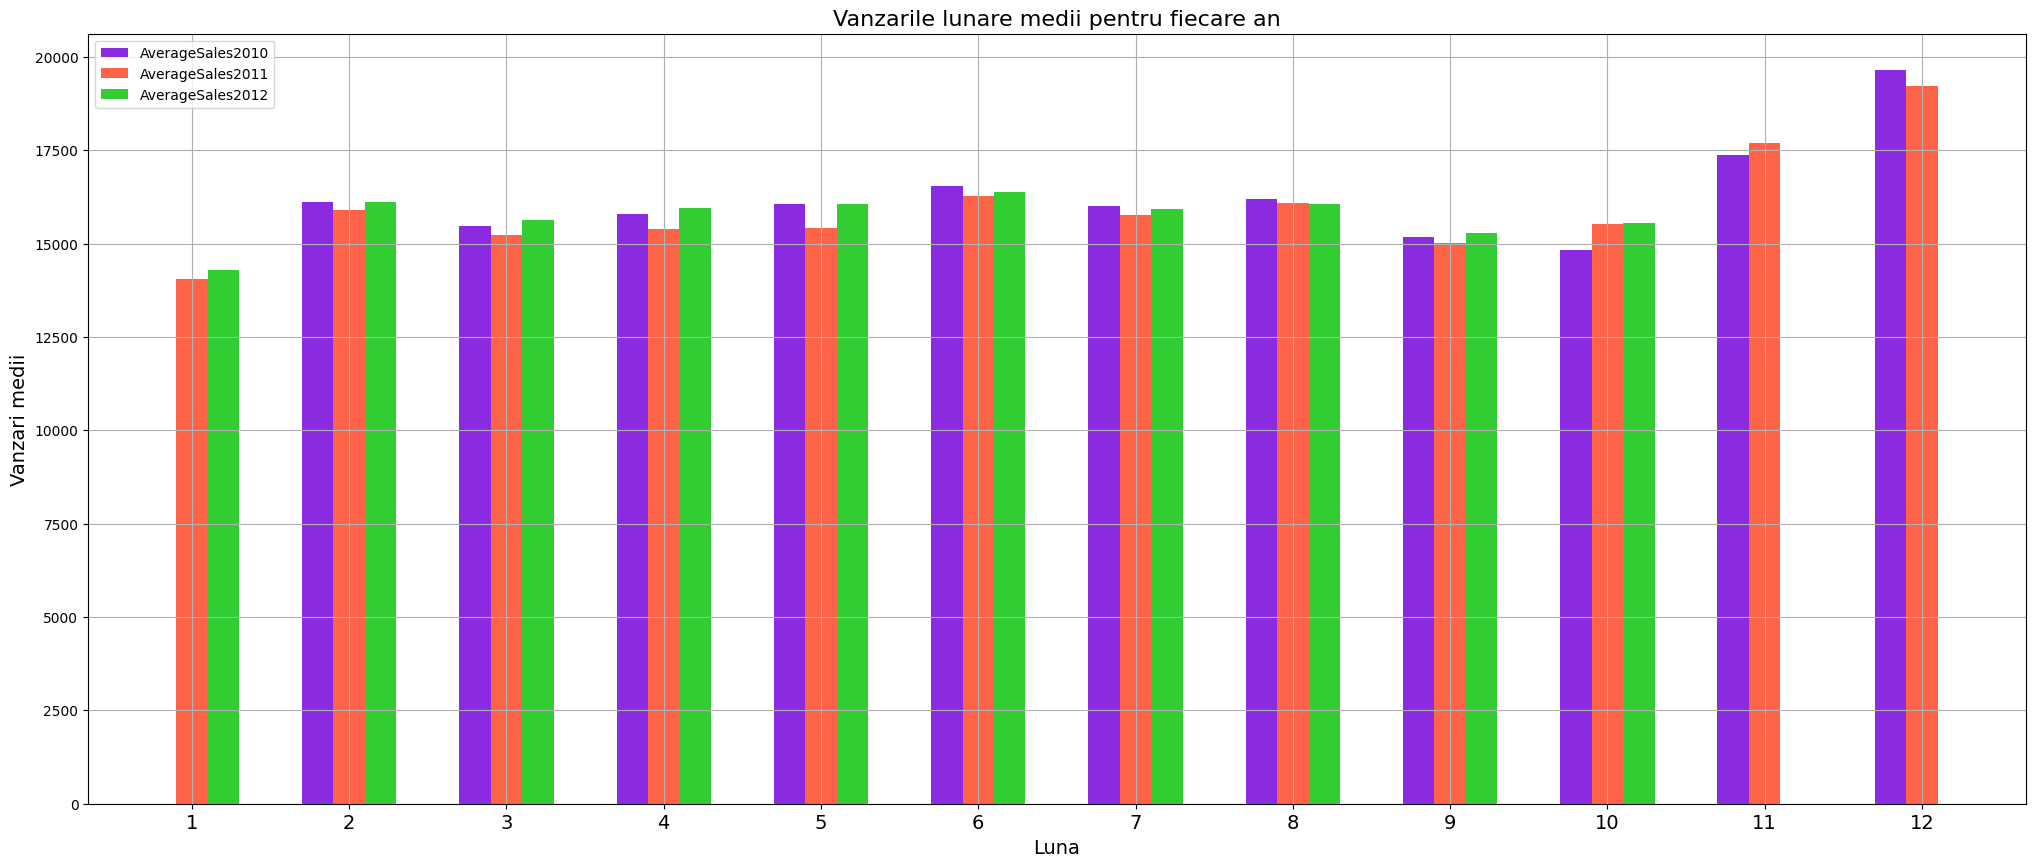

In [20]:
# Filtram datele pentru fiecare an si calculam vanzarile medii lunare
sales_2010 = df[df['Year'] == 2010].groupby('Month')['Weekly_Sales'].mean().reset_index()
sales_2010.rename(columns={'Weekly_Sales': 'AverageSales2010'}, inplace=True)
sales_2011 = df[df['Year'] == 2011].groupby('Month')['Weekly_Sales'].mean().reset_index()
sales_2011.rename(columns={'Weekly_Sales': 'AverageSales2011'}, inplace=True)
sales_2012 = df[df['Year'] == 2012].groupby('Month')['Weekly_Sales'].mean().reset_index()
sales_2012.rename(columns={'Weekly_Sales': 'AverageSales2012'}, inplace=True)

# Unim datele
monthly_merge = pd.merge(sales_2010, sales_2011, on='Month', how='outer')
monthly_merge = pd.merge(monthly_merge, sales_2012, on='Month', how='outer')
monthly_merge.sort_values('Month', inplace=True)

# Creăm graficul utilizând Matplotlib
plt.figure(figsize=(25, 10))
bar_width = 0.2
index = monthly_merge['Month']
bar1 = plt.bar(index - bar_width, monthly_merge['AverageSales2010'], bar_width, label='AverageSales2010', color='blueviolet')
bar2 = plt.bar(index, monthly_merge['AverageSales2011'], bar_width, label='AverageSales2011', color='tomato')
bar3 = plt.bar(index + bar_width, monthly_merge['AverageSales2012'], bar_width, label='AverageSales2012', color='limegreen')

plt.xlabel('Luna', fontsize=14)
plt.ylabel('Vanzari medii', fontsize=14)
plt.title('Vanzarile lunare medii pentru fiecare an', fontsize=16)
plt.xticks(index, fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

* ### Tipul magazinului cu cele mai mari vanzari pe ani


Type              A             B             C
Year                                           
2010  1465450751.06  689988516.41  133479615.55
2011  1578222460.32  724135771.28  145874392.27
2012  1287384267.15  586617360.65  126154013.98


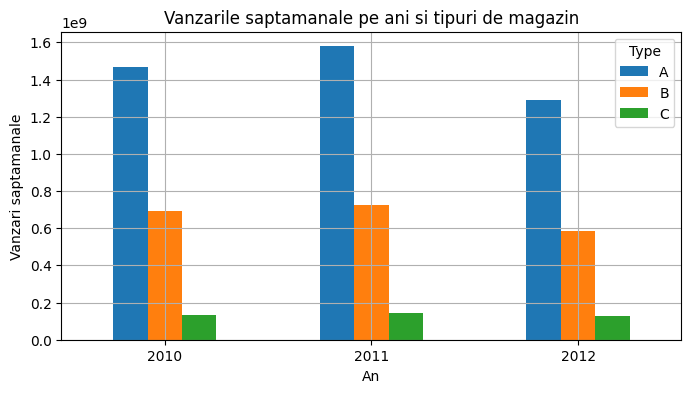

In [21]:
df_sales_by_year_and_type = df.pivot_table(index='Year', columns='Type', values='Weekly_Sales', aggfunc='sum')
print(df_sales_by_year_and_type.map(lambda x: "{:.2f}".format(x))) 

df_sales_by_year_and_type.plot(kind='bar', figsize=(8, 4))
plt.title('Vanzarile saptamanale pe ani si tipuri de magazin')
plt.xlabel('An')
plt.ylabel('Vanzari saptamanale')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(title='Type')
plt.show()
#E posibil sa fie o problema aici.

* ### Holiday vs Non-Holiday Sales
Setul de date furnizat conține date despre vânzările săptămânale ale Walmart în diferite perioade de timp 
dintr-un an, inclusiv date despre vânzările care au loc în perioadele de sărbători, cum ar fi Ziua Recunoștinței, 
Crăciunul, Super Bowl, si Ziua Muncii. \
Este esențial să  comparam diferența dintre vânzările din timpul sărbătorilor și cele din săptămânile normale pentru a înțelege dacă perioada sărbătorilor adună vânzări mai mari. Pentru această comparație, am numărat mai întâi numărul de sărbători dintr-un an și am comparat vânzările în timpul datelor de sărbători față de zilele normale. Deși datele de sărbători au reprezentat doar aproape 7 % din zilele din an, acestea au totuși 
vânzări săptămânale mai mari decât restul anului la un loc (după cum se vede în imaginea de mai jos). Vânzările și  numărătorile "IsHoliday" = TRUE pot fi observate în grafic și evidențiază faptul că, deși numărul de date de  sărbători este mult mai mic decât cel al datelor normale din setul de date, acestea acumulează mai multe vânzări.


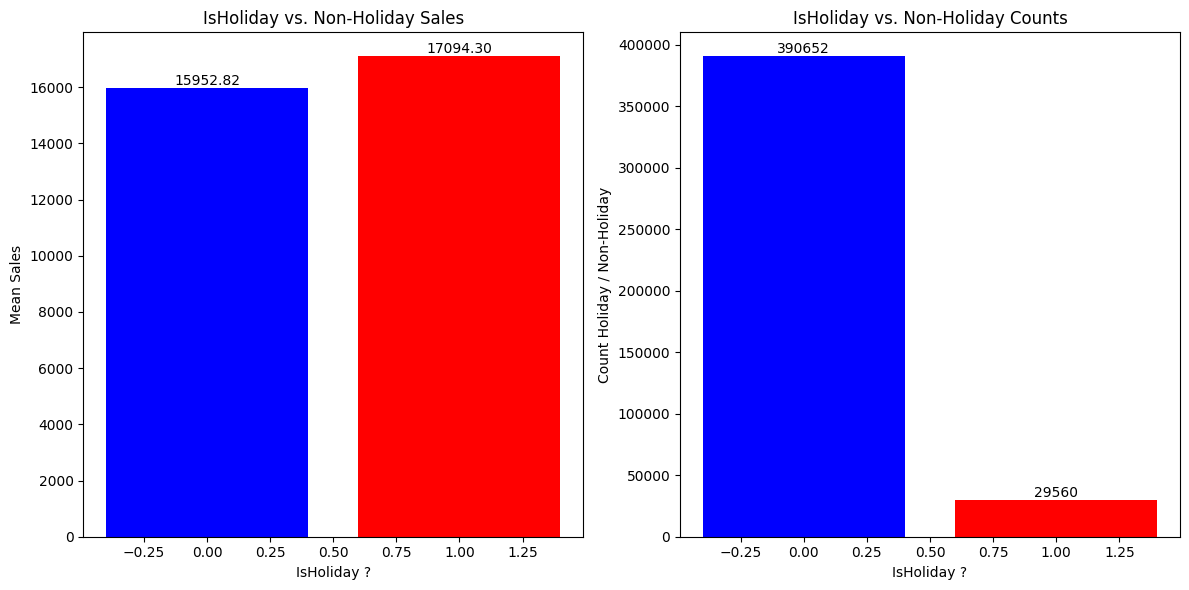

In [22]:
# Calculam vanzarile medii pentru fiecare IsHoliday
sales_holiday = df.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()
# Calculam numarul de aparitii ale 'IsHoliday'
nr_holiday = df['IsHoliday'].value_counts().reset_index()
nr_holiday.columns = ['IsHoliday', 'Count']

plt.figure(figsize=(12, 6))
# Subplot pentru vanzarile medii pentru IsHoliday vs. Non-Holiday
plt.subplot(1, 2, 1)
plt.bar(sales_holiday['IsHoliday'], sales_holiday['Weekly_Sales'], color=['blue', 'red'])
plt.xlabel('IsHoliday ?')
plt.ylabel('Mean Sales')
plt.title('IsHoliday vs. Non-Holiday Sales')
for i in range(len(sales_holiday)):
    plt.text(i, sales_holiday['Weekly_Sales'][i], '{:.2f}'.format(sales_holiday['Weekly_Sales'][i]), ha='center', va='bottom', color='black')
# Subplot pentru numarul de IsHoliday vs. Non-Holiday
plt.subplot(1, 2, 2)
plt.bar(nr_holiday['IsHoliday'], nr_holiday['Count'], color=['blue', 'red'])
plt.xlabel('IsHoliday ?')
plt.ylabel('Count Holiday / Non-Holiday')
plt.title('IsHoliday vs. Non-Holiday Counts')
for i in range(len(nr_holiday)):
    plt.text(i, nr_holiday['Count'][i], str(nr_holiday['Count'][i]), ha='center', va='bottom', color='black')
# Afisam graficele
plt.tight_layout()
plt.show()

* ### Impactul dimensiunii magazinului asupra vanzarilor
S-a aflat dintr-o vizualizarea anterioara că tipul "A" este cel mai mare tip de magazin, urmat de tipul "B" si "C". \
Cateva magazine de tip "B", asa cum este descris mai sus, inregistreaza vanzari medii mai mari decât magazinele de tip "A", ceea ce contravine ideii generale conform careia cu cat dimensiunea magazinului este mai mare, cu atat vanzarile sunt mai mari. Dar, in general, magazinele de tip A prezinta in continuare un volum mare de vanzari, in timp ce magazinele de tip C prezinta un volum de vanzari semnificativ mai mic. \
In concluzie, vanzarile cresc, in general, odata cu cresterea dimensiunii magazinului, cu cateva exceptii minore.


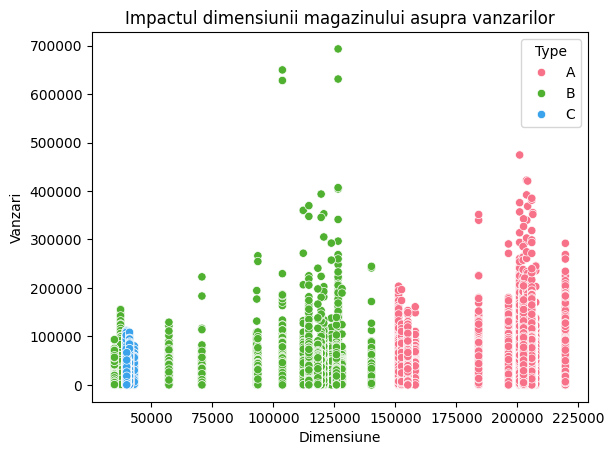

In [23]:
sns.scatterplot(x=df['Size'], y=df['Weekly_Sales'], hue=df['Type'], palette='husl')
plt.xlabel('Dimensiune')
plt.ylabel('Vanzari')
plt.title('Impactul dimensiunii magazinului asupra vanzarilor')
plt.show()

* ### Vanzarile din saptamana anului in functie de tipul de magazin
Cu acest grafic, este clar ca, spre deosebire de tipul de magazin A si B, vanzarile medii nu cresc neaparat pentru 
tipul C la sfarsitul anului, in jurul Zilei Recunostintei si al Craciunului. De asemenea, arata ca magazinele de tip A au de obicei, vanzari saptamanale mai mari in comparatie cu celelalte doua magazine, dovedind inca o data ca o dimensiune mai mare a magazinului inseamna vanzari mai mari.


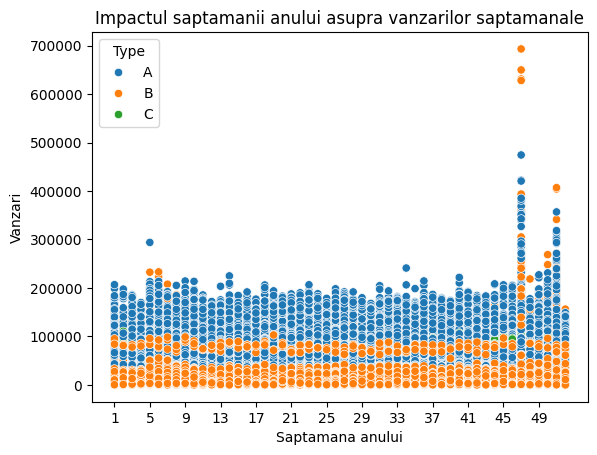

In [24]:
sns.scatterplot(x= df['WeekOfYear'], y=df['Weekly_Sales'], hue=df['Type'])
plt.xlabel('Saptamana anului')
plt.ylabel('Vanzari')
plt.title('Impactul saptamanii anului asupra vanzarilor saptamanale')
plt.legend(title='Type', loc='upper left')
plt.xticks(np.arange(1, 53, step=4))
plt.show()

* ### Impactul temperaturii asupra vanzarilor
__In sectorul comertului cu amanuntul este cunoscut faptul ca vremea are un efect profund asupra vanzarilor. In timp ce vremea mai calda promovează vanzarile, vremea rece sau extrem de calda nu este, in general, o mare incurajare pentru cumparatori sa iasa in aer liber si sa cheltuiască bani.__ \
Dupa cum se vede in imaginea de mai jos, cele mai mari vanzari au loc pentru majoritatea tipurilor de magazine intre 40 si 80 de grade Fahrenheit, dovedind astfel ideea ca vremea placuta incurajeaza vanzari mai mari. Vanzarile sunt relativ mai scazute pentru temperaturi foarte scazute si foarte ridicate, dar par a fi suficient de ridicate pentru conditii climatice favorabile.


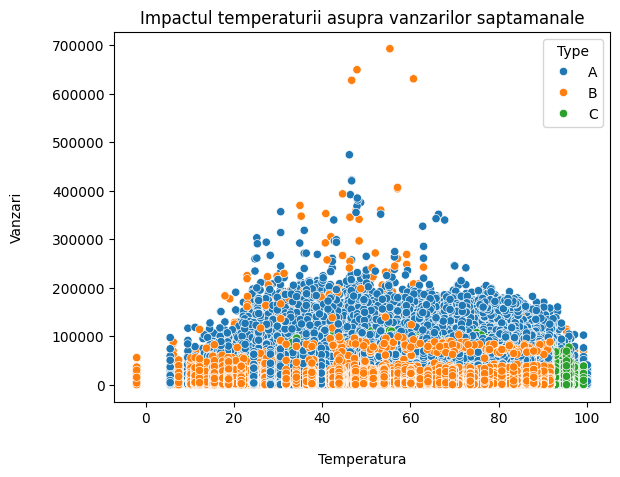

In [25]:
sns.scatterplot(x= df['Temperature'], y= df['Weekly_Sales'], hue= df['Type'])
plt.xlabel('Temperatura', fontsize=10, labelpad=20)
plt.ylabel('Vanzari', fontsize=10, labelpad=20)
plt.title('Impactul temperaturii asupra vanzarilor saptamanale')
plt.show()

* ### Impactul ratei somajului asupra vanzarilor
Pentru tipurile de magazine date, se pare că există o scădere vizibilă a vânzărilor atunci când indicele de șomaj este mai mare de 11. Chiar și atunci când indicele de șomaj este mai mare de 11, nu există  nicio schimbare semnificativă în vânzările medii pentru magazinele de tip  C în comparație cu vânzările generale.\
Se pare că există o scădere semnificativă a vânzărilor  pentru tipurile de magazine A și B atunci când indicele de șomaj crește.\
Cele mai mari vânzări înregistrate pentru tipurile de magazine A și B apar în jurul indicelui de șomaj de 8-10; acest lucru oferă idei ambigue cu privire la impactul șomajului asupra vânzărilor pentru fiecare dintre magazinele.


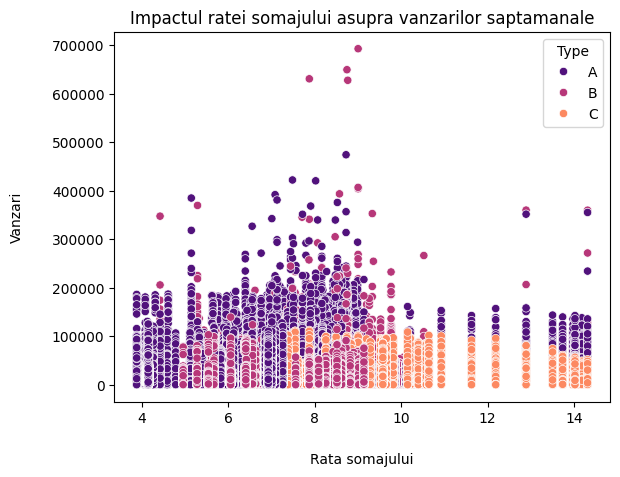

In [26]:
sns.scatterplot(x= df['Unemployment'], y= df['Weekly_Sales'], hue= df['Type'], palette='magma')
plt.xlabel('Rata somajului', fontsize=10, labelpad=20)
plt.ylabel('Vanzari', fontsize=10, labelpad=20)
plt.title('Impactul ratei somajului asupra vanzarilor saptamanale')
plt.show()

* ### Impactul indicelui preturilor de consum asupra vanzarilor
Un IPC mai ridicat înseamnă, în general, că prețul bunurilor a crescut  și că o persoană trebuie să cheltuiască mai mulți bani pentru a menține același standard  de trai.\
În graficul nostru de dispersie de mai jos, putem identifica trei grupuri diferite în jurul a diferite intervale ale IPC; în timp ce nu pare să existe o relație vizibilă între variația în IPC și vânzările săptămânale pentru magazinele Walmart (vânzările au loc în continuare la rate ridicate ale IPC), singura observație neglijabilă care poate fi făcută este valoarea ridicată a vânzărilor pentru magazinul de tip B atunci când IPC este la o rată scăzută de 140.


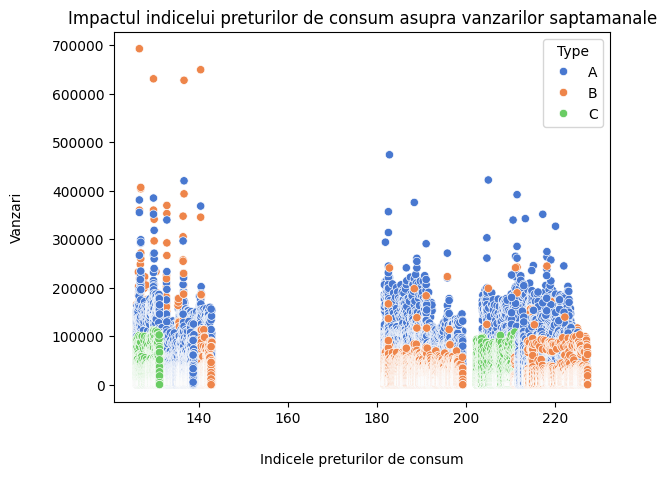

In [27]:
sns.scatterplot(x= df['CPI'], y= df['Weekly_Sales'], hue= df['Type'], palette='muted')
plt.xlabel('Indicele preturilor de consum', fontsize=10, labelpad=20)
plt.ylabel('Vanzari', fontsize=10, labelpad=20)
plt.title('Impactul indicelui preturilor de consum asupra vanzarilor saptamanale')
plt.show()

* ### Impactul pretului combustibilului asupra vanzarilor
In timp ce pare să existe o scădere a vânzărilor atunci când prețul combustibilului este mai mare de 4.25 dolari, vânzările sunt mai mari atunci când prețul combustibilului variază între 2.75 și 3.75 dolari. Unele dintre cele mai mari vânzări pentru tipurile de magazine A și B au loc în această perioadă. Deși nu există un model clar care să dovedească acest lucru, unele observații susțin teoria  conform căreia prețurile mai mici ale carburanților încurajează creșterea vânzărilor



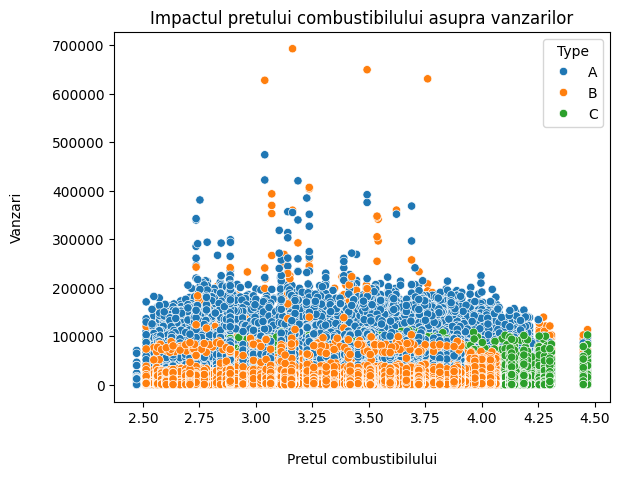

In [28]:
sns.scatterplot(x= df['Fuel_Price'], y= df['Weekly_Sales'], hue= df['Type'])
plt.xlabel('Pretul combustibilului', fontsize=10, labelpad=20)
plt.ylabel('Vanzari', fontsize=10, labelpad=20)
plt.title('Impactul pretului combustibilului asupra vanzarilor')
plt.show()

* ### Creare variabila Type_numeric cu valorile 1, 2, 3 pentru cele 3 tipuri de magazine A, B si C
* ### Creare variabila IsHoliday_numeric cu valorile 0 pentru False si 1 pentru True



In [29]:
df['Type_numeric'] = df['Type'].apply(lambda x: 1 if x == 'A' else (2 if x == 'B' else 3))
df['IsHoliday_numeric'] = df['IsHoliday'].astype(int)
#Vizualizare set de date pentru a observa tranformarile facute
df.head(3)

,Store,Date,IsHoliday,Dept,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,WeekOfYear,Type_numeric,IsHoliday_numeric
0,1,2010-02-05,False,1,24924.50,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,2010,2,5,1,0
1,1,2010-02-05,False,45,37.44,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,2010,2,5,1,0
2,1,2010-02-05,False,28,1085.29,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,2010,2,5,1,0


## Matricea de corelatie 



* #### Există o corelație moderata între vânzările săptămânale și dimensiunea, tipul și departamentul magazinului
* #### Se pare ca exista o corelație negativă între vânzările săptămânale și temperatură, rata șomajului, IPC și prețul combustibilului. Acest lucru ar putea sugera că vânzările nu sunt influențate de schimbările acestor factori.
* #### Reducerile de pret de la 1 la 5 nu par să aibă, de asemenea, o corelație distinctă cu vânzările săptămânale, astfel că nu sunt un factor atât de important în studierea lor.
* #### Cele mai mare corelații sunt intre vânzările săptămânale si: departament(0.15), magazin(0.24), si tipul  magazinului (0.18)


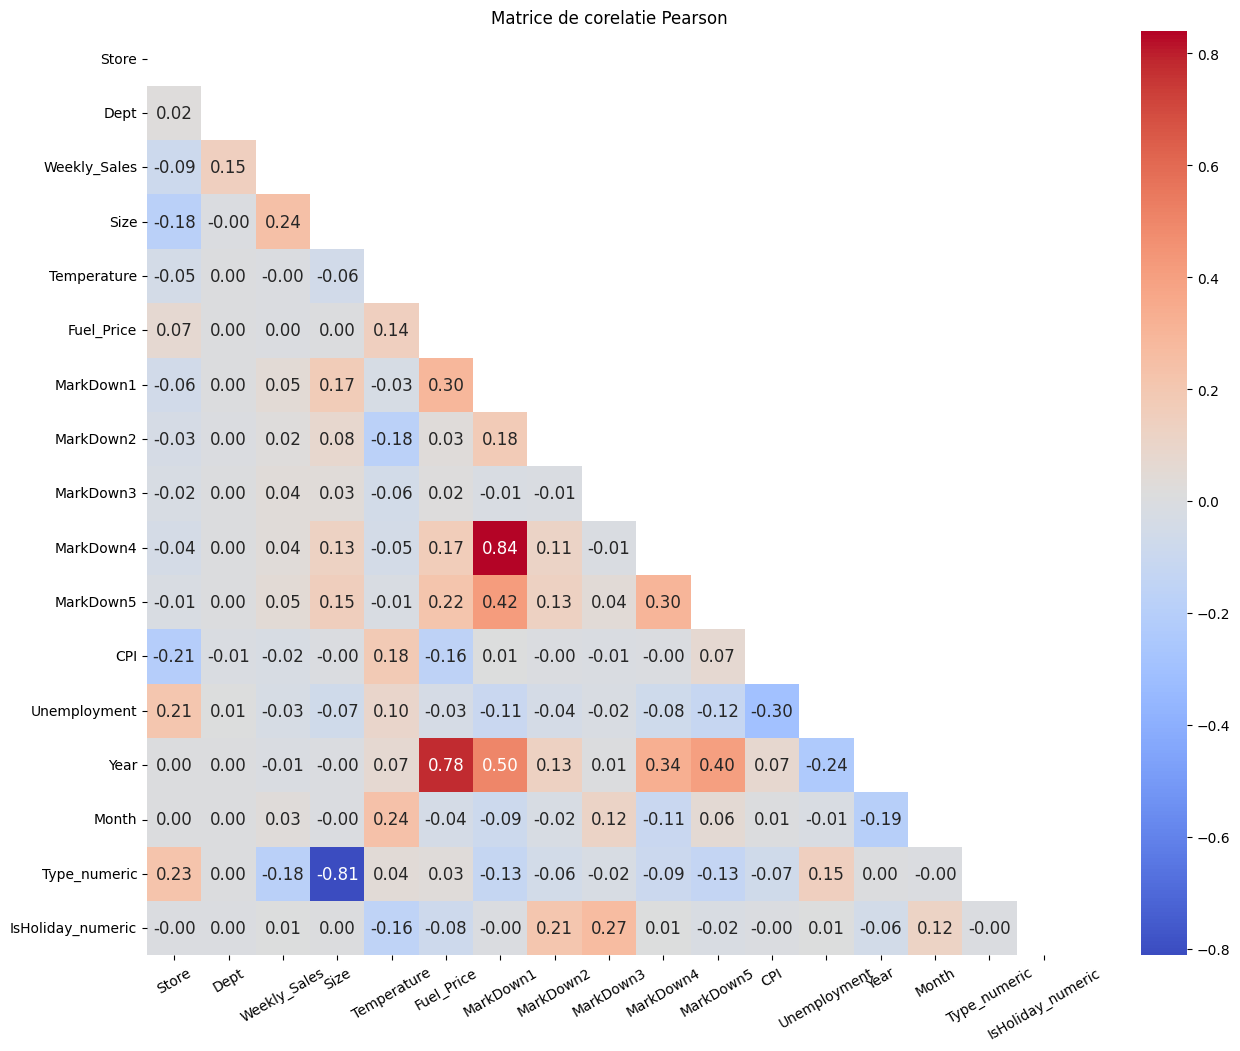

In [30]:
# Selectez doar coloanele numerice din dataframe
numeric_columns = df.select_dtypes(include=['int', 'float'])
# Calculez matricea de corelatie Pearson
correlation_matrix = numeric_columns.corr(method='pearson')
mask = np.triu(correlation_matrix)
# Creez un heatmap folosind biblioteca seaborn
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, annot_kws={'size': 12}, cmap='coolwarm', fmt=".2f", mask = mask, square = True)
plt.title('Matrice de corelatie Pearson')
plt.xticks(rotation=30)
plt.show()

## Pasi pentru realizarea modelelor Machine Learning

In [31]:
#Pastrez doar coloanele de care am nevoie in setul de date si le salvez in dataframe "df2".
df2 = df[['Store', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Size', 'Type_numeric','Year', 'WeekOfYear']]
df2.head()

,Store,IsHoliday,Dept,Weekly_Sales,Size,Type_numeric,Year,WeekOfYear
0,1,False,1,24924.50,151315,1,2010,5
1,1,False,45,37.44,151315,1,2010,5
2,1,False,28,1085.29,151315,1,2010,5
3,1,False,95,106690.06,151315,1,2010,5
4,1,False,3,13740.12,151315,1,2010,5


In [32]:
print('Dimensiunea setului de date df2 este : ', df2.shape)

Dimensiunea setului de date df2 este :  (420212, 8)


### Am filtrat setul de date pentru a include numai vânzările din anul 2011, acest sub-set fiind utilizat pentru dezvoltarea modelelor Machine Learning.

In [33]:
df2_2011 = df2.loc[df2['Year'] == 2011]
print('Dimensiunea setului de date df2_2011 este : ', df2_2011.shape)

Dimensiunea setului de date df2_2011 este :  (152940, 8)


In [34]:
# Transform dataFrame-ul "df2_2011" din Pandas intr-un dataFrame PySpark cu tipuri de date specifice
from pyspark.sql.types import *
# Definesc schema pe baza tipurilor Pandas dataFrame
schema = StructType([
    StructField('Store', IntegerType(), True),
    StructField('IsHoliday', BooleanType(), True),
    StructField('Dept', IntegerType(), True),
    StructField('Weekly_Sales', DoubleType(), True),
    StructField('Size', IntegerType(), True),
    StructField('Type_numeric', IntegerType(), True),
    StructField('Year', IntegerType(), True),
    StructField('WeekOfYear', IntegerType(), True)
])
# Creez PySpark dataFrame cu schema definita
df2_walmart = spark.createDataFrame(df2_2011, schema)

# Afisez dataFrame-ul din PySpark
df2_walmart.show(5, truncate=True)
# Afisez schema dataFrame-ului din PySpark
df2_walmart.printSchema()

24/05/01 19:00:18 WARN TaskSetManager: Stage 4 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.


+-----+---------+----+------------+------+------------+----+----------+
|Store|IsHoliday|Dept|Weekly_Sales|  Size|Type_numeric|Year|WeekOfYear|
+-----+---------+----+------------+------+------------+----+----------+
|    1|    false|  18|     5180.76|151315|           1|2011|         1|
|    1|    false|  19|      955.71|151315|           1|2011|         1|
|    1|    false|  32|     5276.25|151315|           1|2011|         1|
|    1|    false|  56|      946.45|151315|           1|2011|         1|
|    1|    false|  95|   107317.32|151315|           1|2011|         1|
+-----+---------+----+------------+------+------------+----+----------+
only showing top 5 rows

root
 |-- Store: integer (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Type_numeric: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- WeekOfYear: integer (nullable = true)

## Construim data processing pipeline

In [35]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Store','IsHoliday','Dept','Size','Type_numeric','Year','WeekOfYear'], outputCol = 'features')
vfinal_df2_walmart = vectorAssembler.transform(df2_walmart)
vfinal_df2_walmart = vfinal_df2_walmart.select(['features', 'Weekly_Sales'])
vfinal_df2_walmart.show(3)

24/05/01 19:00:28 WARN TaskSetManager: Stage 5 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+
|            features|Weekly_Sales|
+--------------------+------------+
|[1.0,0.0,18.0,151...|     5180.76|
|[1.0,0.0,19.0,151...|      955.71|
|[1.0,0.0,32.0,151...|     5276.25|
+--------------------+------------+
only showing top 3 rows



## Model de regresie liniara pe setul de date vfinal_df2_walmart

In [36]:
from pyspark.ml.regression import LinearRegression

# Creare model de regresie liniară
lr = LinearRegression(featuresCol='features', labelCol='Weekly_Sales')
lr_model = lr.fit(vfinal_df2_walmart)

# Afisare coeficienții si metricele acestuia (ca un fel de summary)
coefficients = lr_model.coefficients.toArray()
coefficients = coefficients.tolist() + [lr_model.intercept]
features = vfinal_df2_walmart.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
feature_names = [feature["name"] for feature in features]
coefficients_df = pd.DataFrame({"Feature": feature_names + ["Intercept"], "Coefficient": coefficients})

evaluation_metrics = {"R^2": lr_model.summary.r2,
    "RMSE": lr_model.summary.rootMeanSquaredError,
    "MAE": lr_model.summary.meanAbsoluteError}
evaluation_df = pd.DataFrame(evaluation_metrics.items(), columns=["Metric", "Value"])

print("Coeficientii modelului de regresie liniara sunt: \n", coefficients_df)
print("\nEvaluare Metrici: \n", evaluation_df)

24/05/01 19:00:36 WARN Instrumentation: [ffafb9f6] regParam is zero, which might cause numerical instability and overfitting.
24/05/01 19:00:36 WARN TaskSetManager: Stage 6 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:00:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/01 19:00:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/05/01 19:00:38 WARN Instrumentation: [ffafb9f6] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/05/01 19:00:40 WARN TaskSetManager: Stage 7 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.


Coeficientii modelului de regresie liniara sunt: 
         Feature  Coefficient
0         Store   -91.142454
1     IsHoliday   905.479903
2          Dept   114.333342
3          Size     0.106146
4  Type_numeric  1978.894480
5          Year     0.000000
6    WeekOfYear    58.513150
7     Intercept -6304.053101

Evaluare Metrici: 
   Metric         Value
0    R^2      0.088021
1   RMSE  21855.465946
2    MAE  14606.377636


### Split the data into 75% and 25% randomly

In [37]:
train_data, test_data = df2_walmart.randomSplit([0.75, 0.25], seed=1234)
print(f"Train set length: {train_data.count()} records")
print(f"Test set length: {test_data.count()} records")

24/05/01 19:00:52 WARN TaskSetManager: Stage 8 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:00:53 WARN TaskSetManager: Stage 11 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.


Train set length: 114845 records
Test set length: 38095 records


### Random Forest fara Cross Validation 

In [38]:
# Aplicam assembler-ul de vectori (vectorAssembler) asupra datelor de antrenare pentru a transforma caracteristicile intr-un singur vector de caracteristici (features).
train_data = vectorAssembler.transform(train_data)

# Aplicam assembler-ul de vectori (vectorAssembler) asupra datelor de testare
test_data = vectorAssembler.transform(test_data)

# Selectam doar variabilele necesare
train_data = train_data.select(['features', 'Weekly_Sales'])
test_data = test_data.select(['features', 'Weekly_Sales'])

In [39]:
#Importam pachetele necesare
from pyspark.ml.evaluation import RegressionEvaluator           #pentru a evalua performanța modelului de regresie.
from pyspark.ml.regression import RandomForestRegressor         #pentru a construi un model de regresie Random Forest.

# Definirea si crearea modelului Random Forest unde am setat hyperparametrul numTree(nr. de abori) la 30
rf_model = RandomForestRegressor(featuresCol='features', labelCol="Weekly_Sales")  
rf_model = rf_model.fit(train_data)

predictions_rf = rf_model.transform(test_data)
# Definirea evaluatorului pentru a evalua performantaa modelului pe baza metricii de eroare medie pătratică (RMSE)

def evaluate_model(predictions):
    evaluator = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction")
    metrics = {
        "RMSE": evaluator.evaluate(predictions, {evaluator.metricName: "rmse"}),
        "R^2": evaluator.evaluate(predictions, {evaluator.metricName: "r2"}),
        "MAE": evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
    }
    return metrics

# Calcularea și afișarea metricilor
metrics = evaluate_model(predictions_rf)
metrics_df = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
print("Random Forest Metrics sunt : \n", metrics_df )

24/05/01 19:01:01 WARN TaskSetManager: Stage 14 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:02 WARN TaskSetManager: Stage 15 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:03 WARN TaskSetManager: Stage 16 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:04 WARN TaskSetManager: Stage 18 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:05 WARN TaskSetManager: Stage 20 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:06 WARN TaskSetManager: Stage 22 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:06 WARN TaskSetManager: Stage 24 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/

Random Forest Metrics sunt : 
   Metric         Value
0   RMSE  17639.758169
1    R^2      0.391548
2    MAE  11184.162209


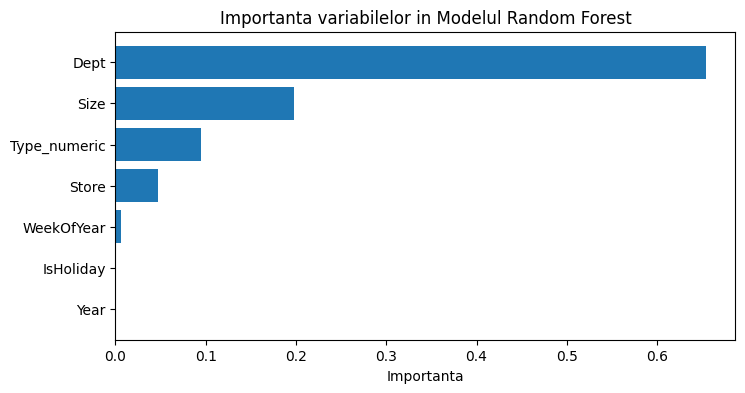

In [40]:
# Extragem caracteristicile din modelul Random Forest
feature_importance = rf_model.featureImportances.toArray()

# Cream un dataframe de tip Pandas cu importanta caracteristicilor si numele acestora
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
# Sortam dataframe-ul dupa importanta lor
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Cream un grafic pentru importanta caracteristicilor
plt.figure(figsize=(8, 4))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importanta")
plt.title("Importanta variabilelor in Modelul Random Forest")
plt.gca().invert_yaxis()  # Inversează axa y pentru a afișa caracteristicile cele mai importante în partea de sus
plt.show()

### Modelul Gradient Boosted Trees Regressor(GBTRegressor)

In [41]:
from pyspark.ml.regression import GBTRegressor
gbt_model = GBTRegressor(featuresCol="features", labelCol="Weekly_Sales") #este setat valoarea implicita maxIter=20
gbt_model = gbt_model.fit(train_data)

#Realizarea predictiilor pe setul de testare:
predictions_gbt = gbt_model.transform(test_data)

#Evaluarea performantei modelului pe baza metricii de eroare medie patratica (RMSE)
def evaluate_model(predictions):
    evaluator = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction")
    metrics = {
        "RMSE": evaluator.evaluate(predictions, {evaluator.metricName: "rmse"}),
        "R^2": evaluator.evaluate(predictions, {evaluator.metricName: "r2"}),
        "MAE": evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
    }
    return metrics

# Calcularea și afișarea metricilor
metrics_gbt = evaluate_model(predictions_gbt)
metrics_df_gbt = pd.DataFrame(metrics_gbt.items(), columns=["Metric", "Value"])
print("GBT Metrics sunt : \n", metrics_df_gbt)


24/05/01 19:01:48 WARN TaskSetManager: Stage 31 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:49 WARN TaskSetManager: Stage 32 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:49 WARN TaskSetManager: Stage 33 contains a task of very large size (2177 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:50 WARN TaskSetManager: Stage 35 contains a task of very large size (2178 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:51 WARN TaskSetManager: Stage 37 contains a task of very large size (2178 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:51 WARN TaskSetManager: Stage 39 contains a task of very large size (2178 KiB). The maximum recommended task size is 1000 KiB.
24/05/01 19:01:51 WARN TaskSetManager: Stage 41 contains a task of very large size (2178 KiB). The maximum recommended task size is 1000 KiB.
24/05/

GBT Metrics sunt : 
   Metric         Value
0   RMSE  14536.666941
1    R^2      0.586790
2    MAE   8701.610187


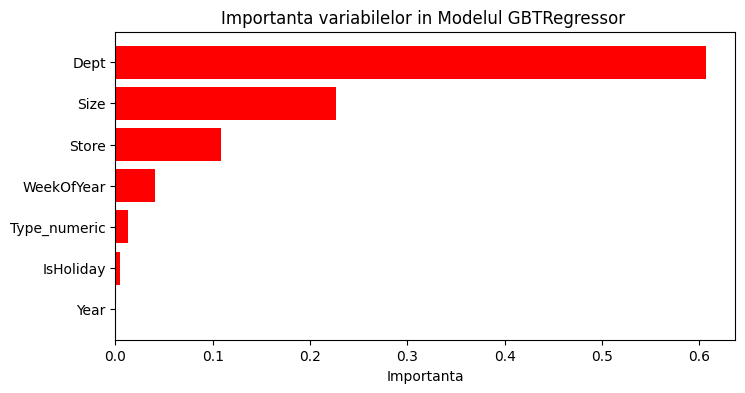

In [42]:
# Extragem caracteristicile din modelul GBTRegressor
feature_importance = gbt_model.featureImportances.toArray()

# Cream un dataframe de tip Pandas cu importanta caracteristicilor si numele acestora
importance_df2 = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
# Sortam dataframe-ul dupa importanta lor
importance_df2 = importance_df2.sort_values(by="Importance", ascending=False)

# Cream un grafic pentru importanta caracteristicilor
plt.figure(figsize=(8, 4))
plt.barh(importance_df2["Feature"], importance_df2["Importance"], color = 'red')
plt.xlabel("Importanta")
plt.title("Importanta variabilelor in Modelul GBTRegressor ")
plt.gca().invert_yaxis()
plt.show()

## Concluzii obtinute in urma realizarii celor doua modele Machine Learning

* __În ambele modele obținute, departamentul (Dept) este cel mai important predictor ce are o influență covârșitoare asupra vânzărilor săptămânale. Pe locul doi este dimensiunea magazinului (Size), iar pe locul trei pentru XGBoost ar fi predictorul Store(magazin) si pentru model RF este predictorul Type_numeric, urmat imediat de predictorul (Store) pe locul patru. Restul predictorilor din ambele modele au o influenta extrem de mica sau aproape deloc asupra vanzarilor saptamanale.__
* __Ambele modele par să ofere o buna potrivire la date, insa modelul GBTRegressor pare să aibă o performanță ușor superioară (este mai bun) în ceea ce privește precizia, dat fiind faptul că are o valoare mai mică a RMSE = 14536.66 și o ușoară îmbunătățire a coeficientului de determinație (R^2 = 0.586790), comparativ cu valorile obtinute pentru modelul de regresie Random Forest (R^2 = 0.391548, RMSE = 17639.758169).__


In [1]:
#se schimba R^2 cand rulezi din nou dupa ce dai restart la kernal.